# Store Sales By Time Series (Analysis Only)

## Imports Libraries

In [1]:
import pandas as pd
import numpy as np

import calendar
import datetime
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

colors = ['#126E82', '#0A043C', '#F25287', '#F0A500', '#7D1935']
plt.style.use('tableau-colorblind10')
sns.set_style('whitegrid')
sns.set_palette(colors)

## Loading DataSets

In [2]:
train_data = pd.read_csv('holiday_train.csv')
test_data = pd.read_csv('holiday_test.csv')
stores = pd.read_csv('stores.csv')
oil = pd.read_csv('oil.csv')
transactions =  pd.read_csv('transactions.csv')
holidays = pd.read_csv('holidays_events.csv')

In [3]:
# rename the column name of oil dataframe.
oil.rename(columns={'dcoilwtico':'oilPrice'}, inplace=True)

# Let's merge oil data into the train and test data
train = train_data.merge(oil, on='date')
test = test_data.merge(oil, on='date') 

In [4]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,oilPrice
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,NaN


In [5]:
test.head()

,id,date,store_nbr,family,onpromotion,oilPrice
0,3000888,2017-08-16,1,AUTOMOTIVE,0,46.8
1,3000889,2017-08-16,1,BABY CARE,0,46.8
2,3000890,2017-08-16,1,BEAUTY,2,46.8
3,3000891,2017-08-16,1,BEVERAGES,20,46.8
4,3000892,2017-08-16,1,BOOKS,0,46.8


In [6]:
print("train shape :", train.shape)
print("test shape :", test.shape)

train shape : (2143746, 7)
test shape : (21384, 6)


In [7]:
# Let's examine holidays dataframe.
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [8]:
train = train.merge(holidays[['date', 'type', 'transferred']], on='date')
train = train.merge(stores, on='store_nbr')
train.rename(columns={'type_x':'holiday_type', 'type_y':'store_type'}, inplace=True)

In [9]:
train.date = pd.to_datetime(train.date)
train['Year'] = train['date'].dt.year
train['Year-Month'] = train['date'].apply(lambda x : x.strftime('%Y-%m'))
train['Month'] = train.date.dt.month
train['Day'] = train.date.dt.day

## INFO & DESCRIBE:

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352836 entries, 0 to 352835
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            352836 non-null  int64         
 1   date          352836 non-null  datetime64[ns]
 2   store_nbr     352836 non-null  int64         
 3   family        352836 non-null  object        
 4   sales         352836 non-null  float64       
 5   onpromotion   352836 non-null  int64         
 6   oilPrice      322542 non-null  float64       
 7   holiday_type  352836 non-null  object        
 8   transferred   352836 non-null  bool          
 9   city          352836 non-null  object        
 10  state         352836 non-null  object        
 11  store_type    352836 non-null  object        
 12  cluster       352836 non-null  int64         
 13  Year          352836 non-null  int64         
 14  Year-Month    352836 non-null  object        
 15  Month         352

In [11]:
train.describe().style.background_gradient(cmap="Blues")

,id,store_nbr,sales,onpromotion,oilPrice,cluster,Year,Month,Day
count,352836.000000,352836.000000,352836.000000,352836.000000,322542.000000,352836.000000,352836.000000,352836.000000,352836.000000
mean,1628315.500000,27.500000,370.968396,3.402351,65.369558,8.481481,2014.949495,7.272727,14.409091
std,795457.461843,15.585806,1196.785036,14.857531,25.489987,4.649741,1.258297,3.326720,9.313809
min,0.000000,1.000000,0.000000,0.000000,27.960000,1.000000,2013.000000,1.000000,1.000000
25%,975199.000000,14.000000,0.000000,0.000000,44.880000,4.000000,2014.000000,4.000000,6.000000
50%,1687553.500000,27.500000,12.000000,0.000000,52.010000,8.500000,2015.000000,7.000000,12.000000
75%,2183840.250000,41.000000,202.000000,0.000000,95.250000,13.000000,2016.000000,11.000000,24.000000
max,3000887.000000,54.000000,124717.000000,716.000000,107.950000,17.000000,2017.000000,12.000000,31.000000


## Missing Data - by Percentage

In [12]:
total = train.isnull().sum().sort_values(ascending=False)
percent = round(100*(train.isnull().sum()/train.isnull().count()).sort_values(ascending=False),2)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data[missing_data['Total']>0]

,Total,Percent
oilPrice,30294,8.59


## Data Analysis

### Sales Distribution

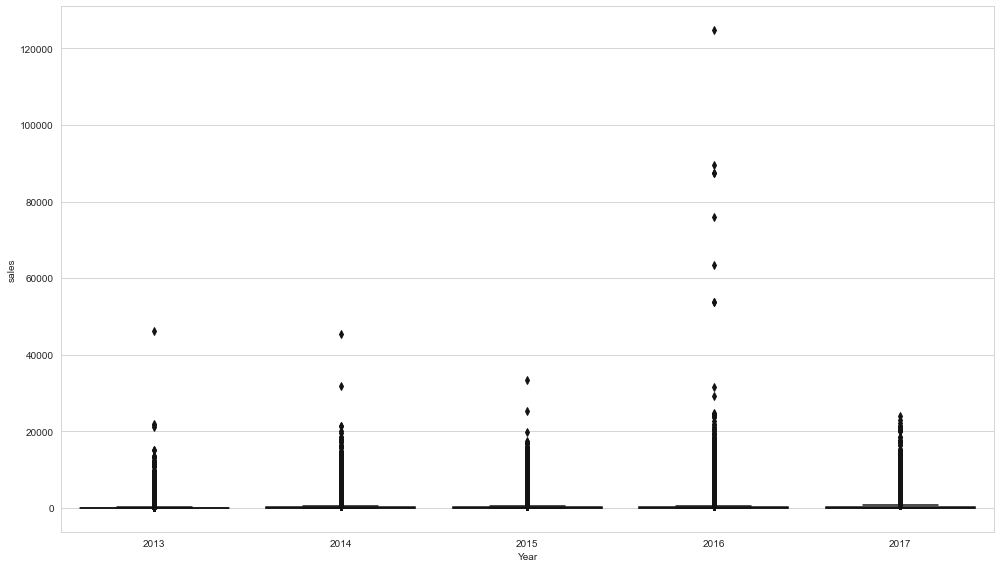

In [13]:
# box plots to see distribution of sales in each year.
plt.figure(figsize=(14, 8))
sns.boxplot(data=train, x='Year', y='sales')

plt.tight_layout()
plt.show()

We can see that, Outliers present in each year, but specifically in year 2016 there are some extreme outliers present which is becasue of earthquake on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake. So, let's remove this extreme outliers in 2016.

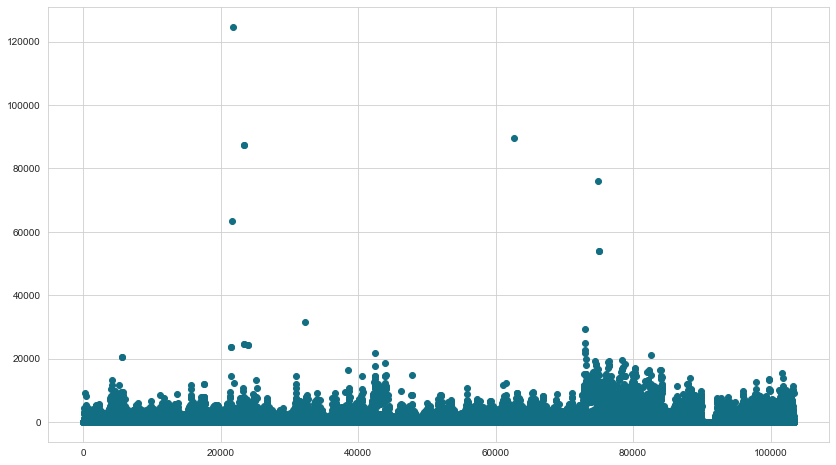

In [14]:
# Let's examine sales in Year 2016
data2016 = train.loc[train.Year == 2016, 'sales']
data2016.reset_index(drop=True, inplace=True)

# plot
plt.figure(figsize=(14, 8))
plt.scatter(data2016.index, data2016.values)
plt.show()

In [15]:
# sales greater than 40000
train.loc[train.sales > 40000].shape # there are 10 entries for sales greater than 40,000.

# Let's remove values greater than 40,000.
train = train.loc[train.sales < 40000]
train.sales.max()

33274.0

### Line plot

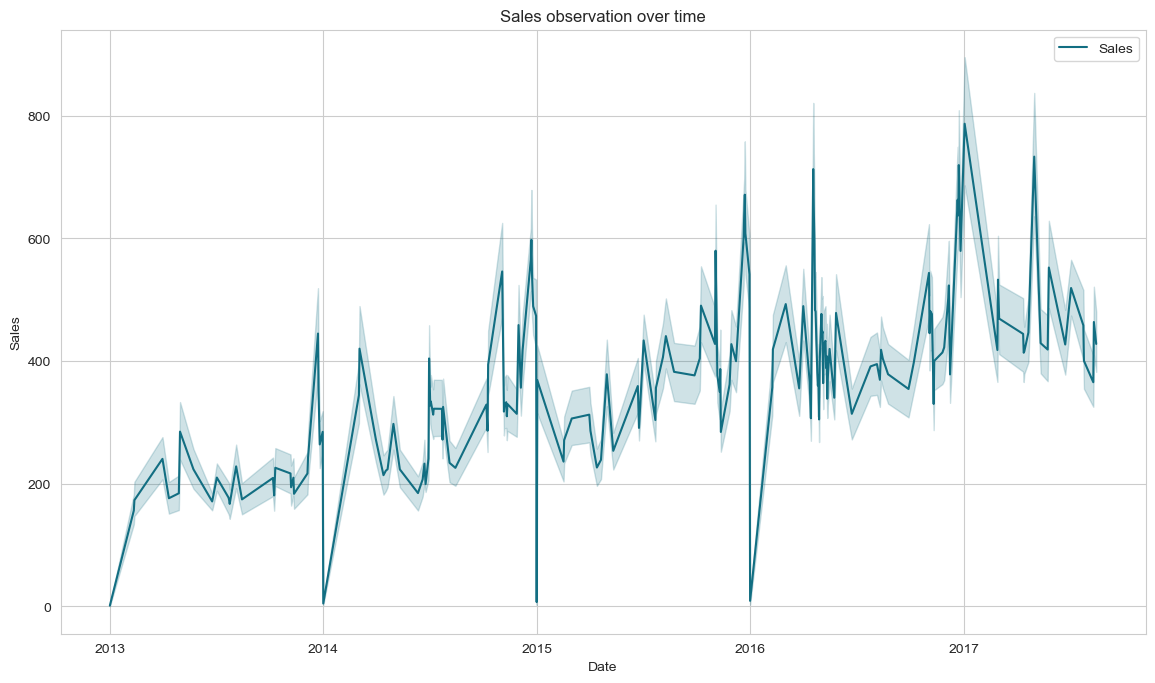

In [16]:
# Sales observation over time.
plt.figure(figsize=(14, 8),dpi=100)
sns.lineplot(data = train, x='date', y='sales', label='Sales')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title("Sales observation over time")

plt.legend()
plt.show()

There is increasing trend or growth in sales over the time.

[]

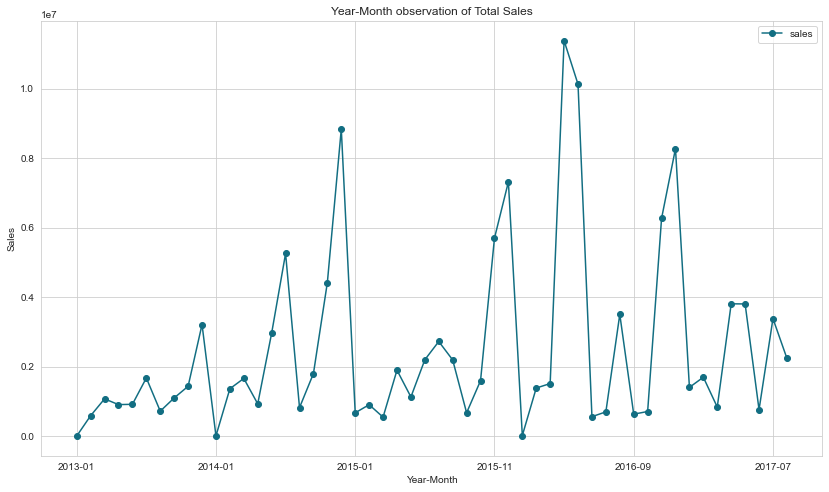

In [17]:
# Year-to-Year observation of sales.
year_data = pd.DataFrame(train.groupby('Year-Month').sum()['sales'])

# plot
year_data.plot(kind='line', figsize=(14, 8), marker="o")

plt.xlabel("Year-Month")
plt.ylabel("Sales")
plt.title("Year-Month observation of Total Sales")
plt.plot()

We can see that, Every year there is Rise in Sales in Month of December and drop in January. This may be because of Christmas. Let's examine the sales over month and see if the same pattern observe in each year.

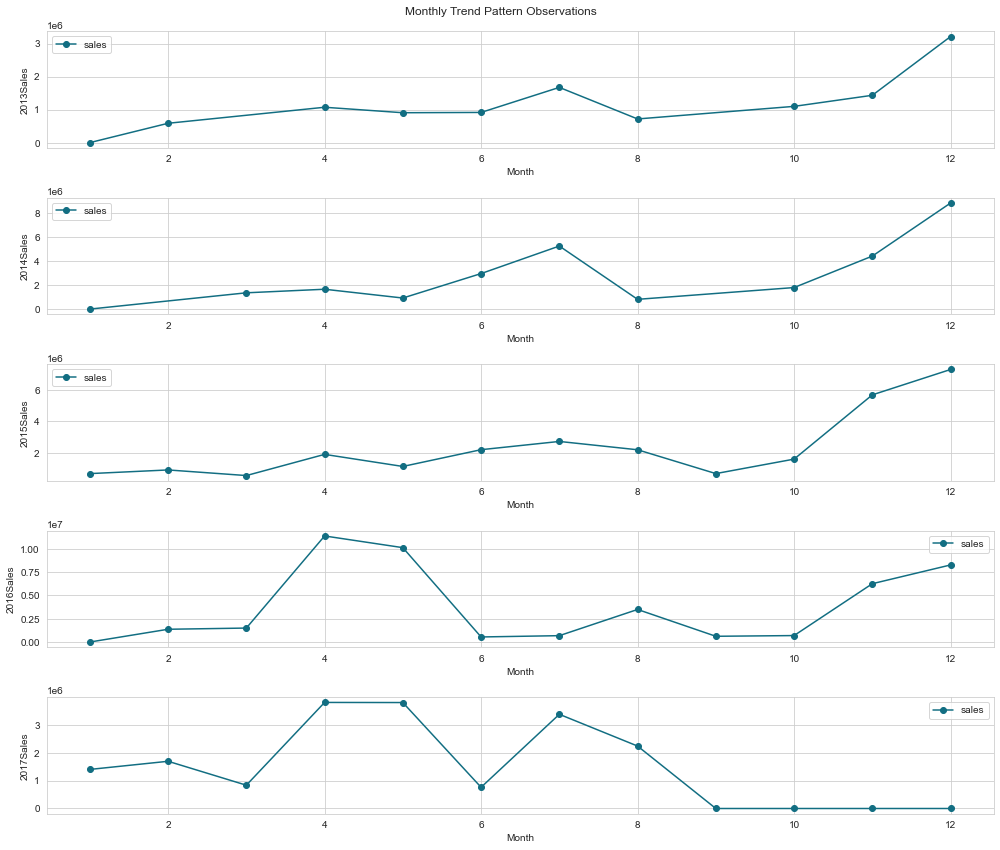

In [18]:
# Monthly observation of Sales for each year.
monthly_sales = pd.DataFrame(train.groupby(by = ['Year', 'Month']).sum()['sales'])

# let's add 0 for remaining months(9, 10, 11, 12) in 2017.
re_months = [9, 10, 11, 12]
for month in re_months:
    monthly_sales.loc[(2017, month), :] = 0
    
yrs = [2013, 2014, 2015, 2016, 2017]

# Plots
fig, axs = plt.subplots(nrows = 5, ncols=1, figsize=(14, 12))
for i in range(len(yrs)):
    yr = yrs[i]
    axs[i] = monthly_sales.loc[yr].plot(ax=axs[i], marker="o", label=yr)
    axs[i].set_ylabel(str(yr)+'Sales')

fig.suptitle("Monthly Trend Pattern Observations")
plt.legend()
plt.tight_layout()
plt.show()

We can see that, There is peak in December month for each year however, at different levels.
Wages in the public sector are paid every two weeks on the 15th and on the last day of the month. Let's observed the sales at 15th day and last day of month.

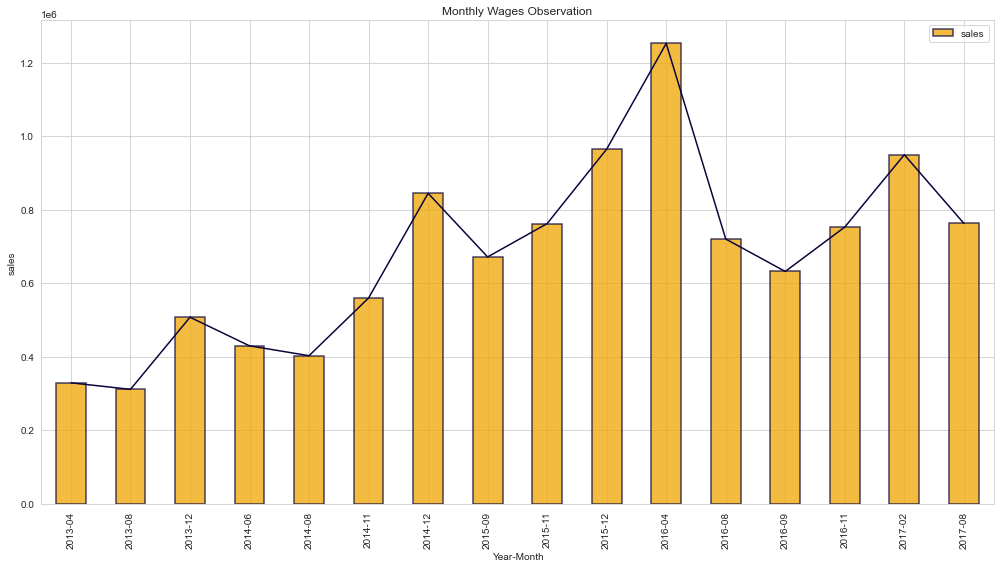

In [19]:
# prepare data
filter1 = (train.Day == 15) 
filter2 = (train.Day.apply(lambda x: x in [31, 30, 29, 28]))

Sales = train.loc[(filter1 | filter2), ['date','Year-Month','sales']]
sales_data = pd.DataFrame(Sales.groupby(by=['Year-Month']).sum())

#plot
sales_data.plot(kind='bar', figsize=(14, 8), edgecolor=colors[1], color=colors[-2], fill=True, alpha=0.75, linewidth=1.5)
sns.lineplot(data = sales_data, x = sales_data.index, y = 'sales', color=colors[1])

plt.title('Monthly Wages Observation')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

We can see that, there is increase in sales in April 2016 as expected.

### Heat map

<AxesSubplot:>

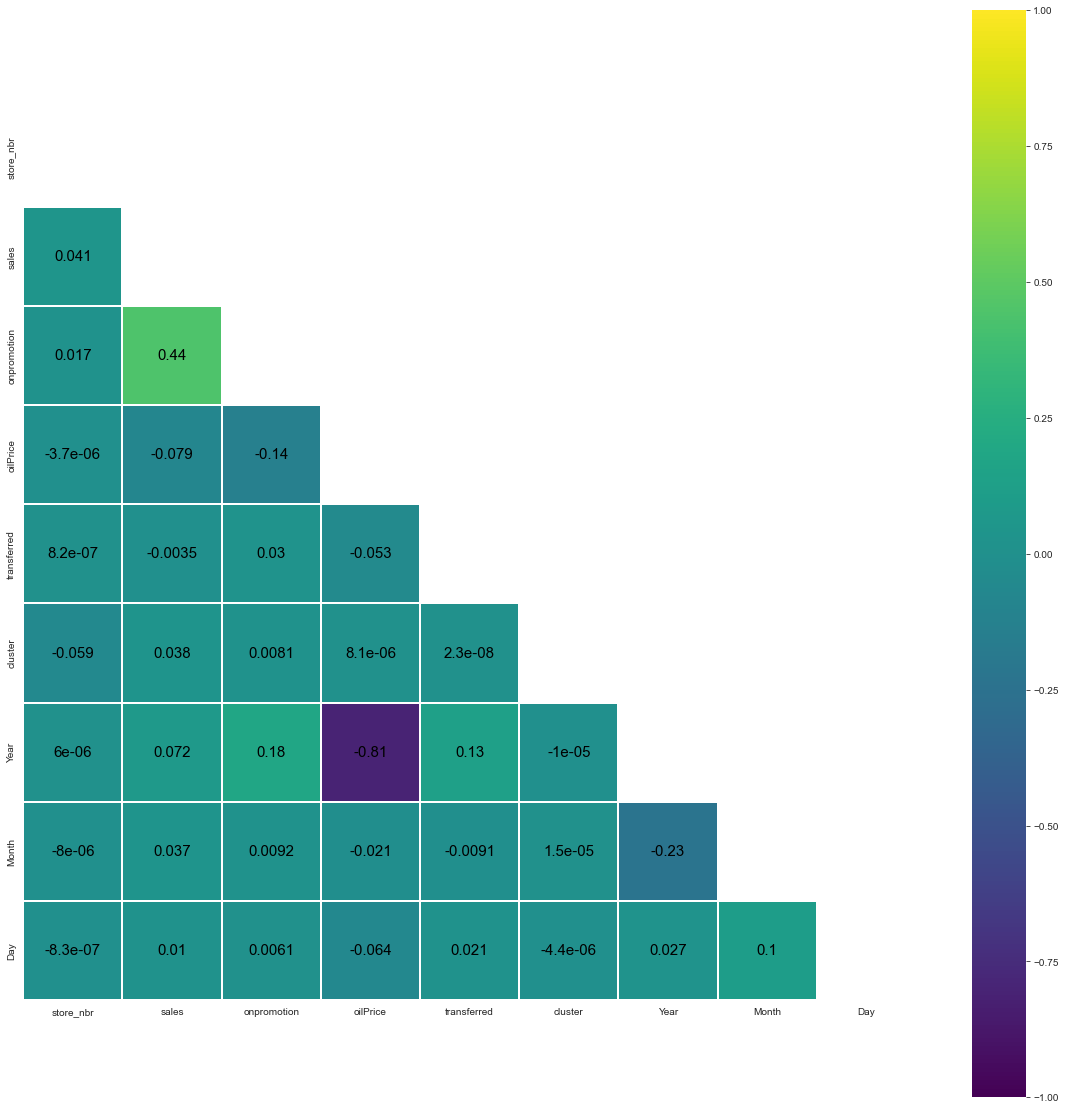

In [20]:
cmap = "viridis"
corr_matrix = train.drop('id',axis=1).corr(method = 'pearson')
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
sns.heatmap(corr_matrix, mask=mask, vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot_kws={"size": 15, "color": "black"}, square=True, cmap=cmap, annot=True)

High reverse correlation between features Year-OilPrice.<br>
Over the years the oil price decline.

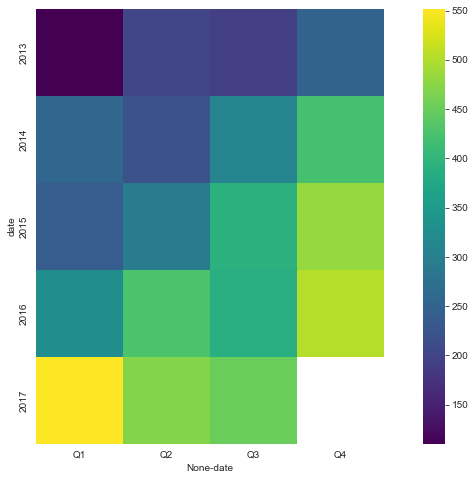

In [21]:
# prepare data
d = train[['date', 'sales']]
d.set_index('date', inplace=True)
ptable = pd.pivot_table(data=d, index=d.index.year, columns=d.index.quarter)

# plot
plt.figure(figsize=(14, 8))
sns.heatmap(ptable,  xticklabels=["Q1", "Q2", "Q3", "Q4"],
           square=True, cmap=cmap)
plt.show()

Heatmap shows peak at Quarter Q4 for every year. For each of the years the upward trend observed in all quarters.

## Seasonality Factor

In [22]:
# Groupby Sales by Quarter
# Only use upto 2016 because we have partial data for 2017
data_2016 = d.loc[:'2016']
avg_2016 = np.int(data_2016.mean())

# Avg sales per quarter
qrt_avg = data_2016.groupby(data_2016.index.quarter)["sales"].mean()

# Groupby quarter
qrt_table = pd.pivot_table(data_2016, index=data_2016.index.quarter, columns=data_2016.index.year)

# add qrt_avg to qrt_table
qrt_table["avg"] = qrt_avg

# Additive Seasonality Factor: Subtract mean from avg column
qrt_table["additive"] = (qrt_table["avg"] - avg_2016).round(2)

# Multiplicative Seasonality Factor: Divide mean from avg column
qrt_table["multiplicative"] = (qrt_table["avg"]/avg_2016).round(2)

qrt_table.index.name="Quarters"
print("Seasonal Factor Analysis Table")
qrt_table

C:\Users\DORONB~1\AppData\Local\Temp/ipykernel_9056/516681882.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  avg_2016 = np.int(data_2016.mean())


Seasonal Factor Analysis Table


sales                                             avg additive  \
date            2013        2014        2015        2016                        
Quarters                                                                        
1         110.351665  256.548073  237.980228  326.811703  245.291179  -109.71   
2         202.983288  222.559189  292.943834  426.904533  328.671785   -26.33   
3         191.659155  309.852124  391.762348  387.365946  321.080238   -33.92   
4         247.927403  422.325064  482.029985  503.159575  424.146800    69.15   

         multiplicative  
date                     
Quarters                 
1                  0.69  
2                  0.93  
3                  0.90  
4                  1.19

Seasonality Analysis table shows that in quarter 4 we can see that there is increament in sales by ~69k as compare to others and there is sudden drop in quarter <br>
in-addition as we can see from the above table is that the sales is not stable, The multiplicative seasonallity would capture the pattern better than additive seasonality.

## Stationarity

Time series is Stationary if it has:<br>
1. Constant Mean<br>
2.Constant Variance<br>
3.Constant Covariance<br>

Let's verify it by observing change in mean, variance and statistical test (adfuller)

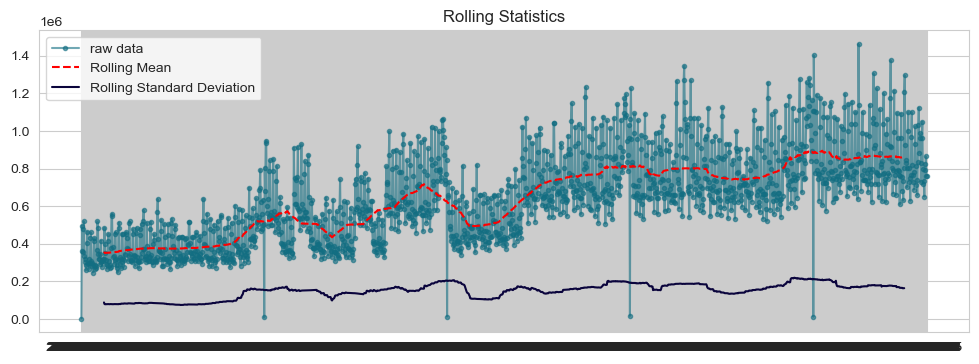

In [23]:
# prepare_data 
data = pd.DataFrame(train_data.groupby(by=['date']).sum()['sales'])

def test_stationarity(timeseries, title):
    
    # calculating rolling statistics.
    roll_mean = timeseries['sales'].rolling(window = 91,  center=True).mean()
    roll_std = timeseries['sales'].rolling(window = 91,  center=True).std()

    # plotting rolling statistics with orignal data.
    plt.figure(figsize=(12, 4), dpi=100)
    plt.plot(timeseries.sales, label= title, marker=".", alpha=0.6)
    plt.plot(roll_mean, label="Rolling Mean", color="red", linestyle="--")
    plt.plot(roll_std, label="Rolling Standard Deviation")

    plt.title("Rolling Statistics")
    plt.legend()
    plt.show()

test_stationarity(data, 'raw data')

Above plot show that, Both Mean and Standard deviation is increasing over time. Therefore, this time series is not stationary.

Coefficient of Variance <br>
C.V = std/mean<br>

1. If C.V<0.75 - Low Variability<br>
2. If 0.75<C.V<1.3 - Medium Variability<br>
3. If C.V>1.3 - High Variability<br>


In [24]:
# coefficient of variance. 
cv = data.sales.std()/data.sales.mean()
cv

0.36766982379276875

This has low variability process.

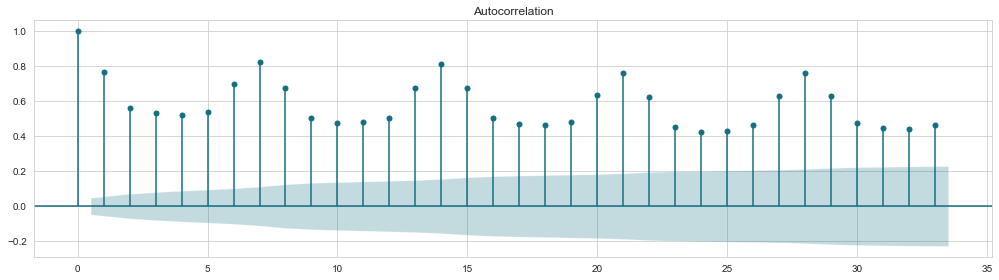

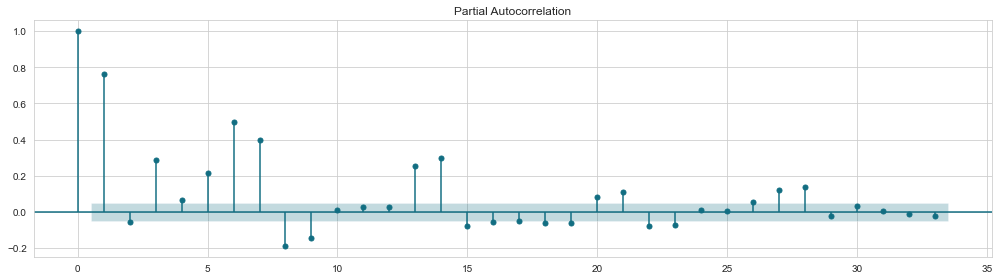

In [25]:
# Let's find if covariance is constant or not using acf plot and pacf plot of statsmodels.
plt.rcParams['figure.figsize'] = (14, 4);
plot_acf(data.sales);
plt.tight_layout()
plot_pacf(data.sales);
plt.tight_layout()

The ACF Plot shows that, it has momentum process since all AC's are positive. Let's check stationarity of data using Augmented Dickey-fuller test (adfuller test).

## ADFuller Test

In [26]:
# Let's take a adfuller test on sales data.

def adfuller_test(data, description):
    
    print(f"Augmented Dickey-fuller test result for {description}")
    result = adfuller(data.dropna(), autolag="AIC")
    
    print("ADF test statistic: {:.3f}".format(result[0]))
    print("p-value:{:.3f}".format(result[1]))
    
    print("Critical Values:")
    for k, v in result[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<result[0] else '', 100-int(k[:-1])))
        
adfuller_test(data, 'raw data')

Augmented Dickey-fuller test result for raw data
ADF test statistic: -2.616
p-value:0.090
Critical Values:
	1%: -3.4342930672797065 - The data is not stationary with 99% confidence
	5%: -2.8632816397229064 - The data is not stationary with 95% confidence
	10%: -2.567697207194407 - The data is  stationary with 90% confidence


Augmented Dickey-fuller test is a statistical test for stationarity. If the p-value is less than 0.05 then the series is not stationary. Here the p-value is ~0.08989 so, the time series is not stationary.

## To make Time Series Stationary

### Detrend

Augmented Dickey-fuller test result for de-trended data
ADF test statistic: -6.667
p-value:0.000
Critical Values:
	1%: -3.434519329789117 - The data is  stationary with 99% confidence
	5%: -2.863381509434791 - The data is  stationary with 95% confidence
	10%: -2.56775038703571 - The data is  stationary with 90% confidence


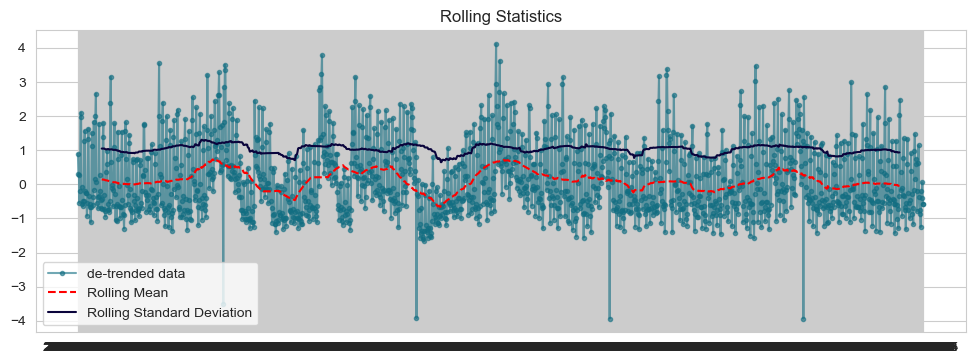

In [27]:
# de-trending
data_detrend = ((data - data.rolling(91).mean()) / data.rolling(91).std()).dropna()

# To check if detrended data is stationary or not?
adfuller_test(data_detrend, "de-trended data")
test_stationarity(data_detrend, "de-trended data")

Both the adfuller statistical test and rolling statistics graph shows that the series is now stationary. The relative smoothness of rolling mean and rolling standard deviation graph shows the sationarity in time series.

## Differencing

This method removes the underlying seasonal or cyclical patterns in the time series. I used a 15-lag difference since wages in public sector is paid every 2 weeks.

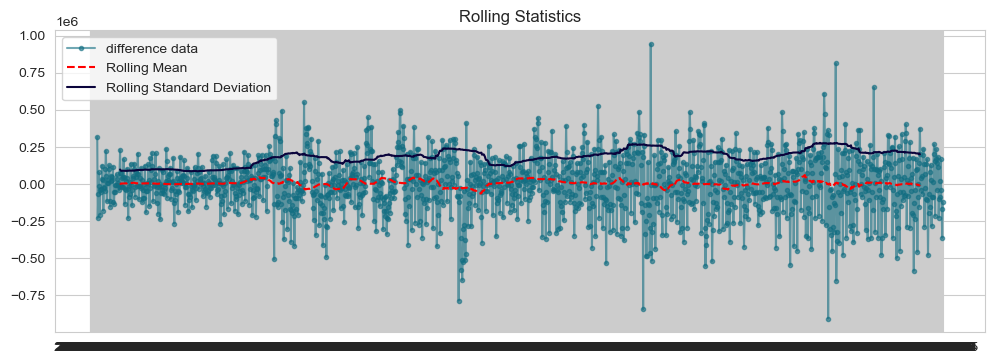

Augmented Dickey-fuller test result for difference data
ADF test statistic: -9.292
p-value:0.000
Critical Values:
	1%: -3.4343363335985666 - The data is  stationary with 99% confidence
	5%: -2.8633007375690576 - The data is  stationary with 95% confidence
	10%: -2.5677073765535114 - The data is  stationary with 90% confidence


In [28]:
diff_data = (data - data.shift(15))
test_stationarity(diff_data, 'difference data')
adfuller_test(diff_data, 'difference data')

Both stationarity tests shows that, the this time series is stationary. Differencing performs much better as compare to de-trending.